In [1]:
rm -r /kaggle/working/*

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

2022-07-30 02:32:00.627881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-30 02:32:04.900763: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-07-30 02:32:04.904018: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-30 02:32:04.907240: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-30 02:32:04.970188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 02:32:04.970863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-07-30 02:32:04.970929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-30 02:32:05.015858: I tensorflow/stream_executor/platform/def

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np # linear algebra
from pathlib import Path
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import sparse
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from warnings import simplefilter

simplefilter('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [4]:
model_name = 'nn_v2'

## Baseline

In [5]:
import glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import gc
import pathlib
from scipy.interpolate import InterpolatedUnivariateSpline

INPUT_PATH = '../input/smartphone-decimeter-2022'

WGS84_SEMI_MAJOR_AXIS = 6378137.0
WGS84_SEMI_MINOR_AXIS = 6356752.314245
WGS84_SQUARED_FIRST_ECCENTRICITY  = 6.69437999013e-3
WGS84_SQUARED_SECOND_ECCENTRICITY = 6.73949674226e-3

HAVERSINE_RADIUS = 6_371_000

In [6]:
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['SvElevationDegrees'] > 10.0  # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0  # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0 # Multipath flag

    return df[idx]

In [7]:
@dataclass
class ECEF:
    x: np.array
    y: np.array
    z: np.array

    def to_numpy(self):
        return np.stack([self.x, self.y, self.z], axis=0)

    @staticmethod
    def from_numpy(pos):
        x, y, z = [np.squeeze(w) for w in np.split(pos, 3, axis=-1)]
        return ECEF(x=x, y=y, z=z)

@dataclass
class BLH:
    lat : np.array
    lng : np.array
    hgt : np.array

def ECEF_to_BLH(ecef):
    a = WGS84_SEMI_MAJOR_AXIS
    b = WGS84_SEMI_MINOR_AXIS
    e2  = WGS84_SQUARED_FIRST_ECCENTRICITY
    e2_ = WGS84_SQUARED_SECOND_ECCENTRICITY
    x = ecef.x
    y = ecef.y
    z = ecef.z
    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(z * (a/b), r)
    B = np.arctan2(z + (e2_*b)*np.sin(t)**3, r - (e2*a)*np.cos(t)**3)
    L = np.arctan2(y, x)
    n = a / np.sqrt(1 - e2*np.sin(B)**2)
    H = (r / np.cos(B)) - n
    return BLH(lat=B, lng=L, hgt=H)

def haversine_distance(blh_1, blh_2):
    dlat = blh_2.lat - blh_1.lat
    dlng = blh_2.lng - blh_1.lng
    a = np.sin(dlat/2)**2 + np.cos(blh_1.lat) * np.cos(blh_2.lat) * np.sin(dlng/2)**2
    dist = 2 * HAVERSINE_RADIUS * np.arcsin(np.sqrt(a))
    return dist


def pandas_haversine_distance(df1, df2):
    blh1 = BLH(
        lat=np.deg2rad(df1['LatitudeDegrees'].to_numpy()),
        lng=np.deg2rad(df1['LongitudeDegrees'].to_numpy()),
        hgt=0,
    )
    blh2 = BLH(
        lat=np.deg2rad(df2['LatitudeDegrees'].to_numpy()),
        lng=np.deg2rad(df2['LongitudeDegrees'].to_numpy()),
        hgt=0,
    )
    return haversine_distance(blh1, blh2)

In [8]:
def ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis):
    """
    Convert Earth-Centered Earth-Fixed to Latitude and Longitude.
    
    Returns dataframe with tripID, position, and time. 
    """
    ecef_columns = ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']
    columns = ['utcTimeMillis'] + ecef_columns
    ecef_df = (gnss_df.drop_duplicates(subset='utcTimeMillis')[columns]
               .dropna().reset_index(drop=True))
    ecef = ECEF.from_numpy(ecef_df[ecef_columns].to_numpy())
    blh  = ECEF_to_BLH(ecef)

    TIME = ecef_df['utcTimeMillis'].to_numpy()
    lat = InterpolatedUnivariateSpline(TIME, blh.lat, ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(TIME, blh.lng, ext=3)(UnixTimeMillis)
    return pd.DataFrame({
        'tripId' : tripID,
        'UnixTimeMillis'   : UnixTimeMillis,
        'LatitudeDegrees'  : np.degrees(lat),
        'LongitudeDegrees' : np.degrees(lng),
    })

def calc_score(tripID, pred_df, gt_df):
    d = pandas_haversine_distance(pred_df, gt_df)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])    
    return score

In [9]:
%%capture --no-stdout

pred_dfs  = []
imu_dfs = []
gnss_dfs = []
score_list = []
for dirname in tqdm(sorted(glob.glob(f'{INPUT_PATH}/train/*/*'))):
    drive, phone = dirname.split('/')[-2:]
    tripID  = f'{drive}/{phone}'
    # Load .csv files to dataframes
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv', 
                          usecols=['utcTimeMillis',
                                   'WlsPositionXEcefMeters', 
                                   'WlsPositionYEcefMeters', 
                                   'WlsPositionZEcefMeters',
                                   'SvElevationDegrees',
                                   'Cn0DbHz',
                                   'MultipathIndicator'])
    imu_df = pd.read_csv(f'{dirname}/device_imu.csv')
    gt_df = pd.read_csv(f'{dirname}/ground_truth.csv', usecols=['UnixTimeMillis','LatitudeDegrees','LongitudeDegrees','AltitudeMeters'])
    
    # Append dfs in list
    df_pr = satellite_selection(gnss_df, 'utcTimeMillis')
    gnss_dfs.append(df_pr)
    imu_dfs.append(imu_df)
    
    # Convert ECEF to lat/long data
    pred_df = ecef_to_lat_lng(tripID, df_pr, gt_df['UnixTimeMillis'].to_numpy())
    pred_dfs.append(pred_df)
    
    # Calc score
    score = calc_score(tripID, pred_df, gt_df)
    print(f'{tripID:<45}: score = {score:.3f}')
    score_list.append(score)
    del gnss_df
    gc.collect()
    # del df_pr
    # gc.collect()
    del imu_df
    gc.collect()
    del pred_df
    gc.collect()
    del gt_df
    gc.collect()
print('done')

2020-05-15-US-MTV-1/GooglePixel4XL           : score = 4.319
2020-05-21-US-MTV-1/GooglePixel4             : score = 3.434
2020-05-21-US-MTV-1/GooglePixel4XL           : score = 2.277
2020-05-21-US-MTV-2/GooglePixel4             : score = 2.121
2020-05-21-US-MTV-2/GooglePixel4XL           : score = 2.464
2020-05-28-US-MTV-2/GooglePixel4             : score = 2.938
2020-05-28-US-MTV-2/GooglePixel4XL           : score = 2.191
2020-05-29-US-MTV-1/GooglePixel4             : score = 2.814
2020-05-29-US-MTV-1/GooglePixel4XL           : score = 2.489
2020-05-29-US-MTV-2/GooglePixel4             : score = 2.930
2020-05-29-US-MTV-2/GooglePixel4XL           : score = 2.786
2020-06-04-US-MTV-1/GooglePixel4             : score = 2.405
2020-06-04-US-MTV-1/GooglePixel4XL           : score = 1.754
2020-06-04-US-MTV-2/GooglePixel4             : score = 2.351
2020-06-04-US-MTV-2/GooglePixel4XL           : score = 2.293
2020-06-05-US-MTV-1/GooglePixel4             : score = 2.086
2020-06-05-US-MTV-1/Goog

In [10]:
mean_score = np.mean(score_list)
print(f'mean_score = {mean_score:.3f}')
del score_list
gc.collect()

mean_score = 4.328


21

In [11]:
# Check head of raw gnss data
gnss_train_df = pd.concat(gnss_dfs)
gnss_train_df.head()

,utcTimeMillis,Cn0DbHz,MultipathIndicator,SvElevationDegrees,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,1589573679445,21.5,0,47.347860,-2.693907e+06,-4.297452e+06,3.854203e+06
1,1589573679445,39.7,0,61.921893,-2.693907e+06,-4.297452e+06,3.854203e+06
2,1589573679445,32.1,0,31.902861,-2.693907e+06,-4.297452e+06,3.854203e+06
3,1589573679445,26.6,0,34.059610,-2.693907e+06,-4.297452e+06,3.854203e+06
4,1589573679445,28.7,0,55.366606,-2.693907e+06,-4.297452e+06,3.854203e+06


In [12]:
# Check head of raw imu data
imu_train_df = pd.concat(imu_dfs)
imu_train_df.head()

,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,UncalAccel,1589573679447,0.237913,9.250001,1.784782,0.00000,0.000000,0.00000
1,UncalGyro,1589573679450,-0.022198,0.004974,0.014298,0.00000,0.000000,0.00000
2,UncalMag,1589573679450,2.812906,-37.320263,-1.189655,74.85504,-10.046193,-44.48028
3,UncalAccel,1589573679457,0.134411,9.673122,1.313673,0.00000,0.000000,0.00000
4,UncalMag,1589573679460,2.601327,-37.849490,-0.733490,74.85504,-10.046193,-44.48028


In [13]:
baseline_train_df = pd.concat(pred_dfs)  
baseline_train_df['drive'], baseline_train_df['phone'] = baseline_train_df['tripId'].str.split('/', 1).str
baseline_train_df.to_csv('baseline_train.csv', index=False)

In [14]:
sample_df = pd.read_csv(f'{INPUT_PATH}/sample_submission.csv')
pred_dfs  = []
for dirname in tqdm(sorted(glob.glob(f'{INPUT_PATH}/test/*/*'))):
    drive, phone = dirname.split('/')[-2:]
    tripID  = f'{drive}/{phone}'
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
    UnixTimeMillis = sample_df[sample_df['tripId'] == tripID]['UnixTimeMillis'].to_numpy()
    pred_dfs.append(ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis))
baseline_test_df = pd.concat(pred_dfs)
baseline_test_df['drive'], baseline_test_df['phone'] = baseline_test_df['tripId'].str.split('/', 1).str
baseline_test_df.to_csv('baseline_test.csv', index=False)
# baseline_test_df.to_csv('submission.csv', index=False) # Commented out for further post-processing than only baseline

  0%|          | 0/36 [00:00<?, ?it/s]

In [15]:
base_train = pd.read_csv('./' + 'baseline_train.csv')
base_test = pd.read_csv('./' + 'baseline_test.csv')
sample_sub = pd.read_csv(INPUT_PATH + '/' + 'sample_submission.csv')

In [16]:
gts = []
# ground_truth
for dirname in sorted(glob.glob(f'{INPUT_PATH}/train/*/*')):
    drive, phone = dirname.split('/')[-2:]
    tripID  = f'{drive}/{phone}'
    # Load .csv files to dataframe
    gt_df = pd.read_csv(f'{dirname}/ground_truth.csv')
    gt_df.insert(loc=0,column='phone',value=phone)
    gt_df.insert(loc=0,column='drive',value=drive)
    # Append dfs in list
    gts.append(gt_df)
ground_truth = pd.concat(gts)

## reject outlier 

In [17]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [18]:
base_train

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,drive,phone
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,2020-05-15-US-MTV-1,GooglePixel4XL
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,2020-05-15-US-MTV-1,GooglePixel4XL
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,2020-05-15-US-MTV-1,GooglePixel4XL
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,37.416542,-122.082077,2020-05-15-US-MTV-1,GooglePixel4XL
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,37.416538,-122.082078,2020-05-15-US-MTV-1,GooglePixel4XL
...,...,...,...,...,...,...
295628,2021-12-28-US-MTV-1/XiaomiMi8,1640724240000,37.416021,-122.080936,2021-12-28-US-MTV-1,XiaomiMi8
295629,2021-12-28-US-MTV-1/XiaomiMi8,1640724241000,37.416016,-122.080935,2021-12-28-US-MTV-1,XiaomiMi8
295630,2021-12-28-US-MTV-1/XiaomiMi8,1640724242000,37.416027,-122.080940,2021-12-28-US-MTV-1,XiaomiMi8
295631,2021-12-28-US-MTV-1/XiaomiMi8,1640724243000,37.416036,-122.080944,2021-12-28-US-MTV-1,XiaomiMi8


In [19]:
base_test

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,drive,phone
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395828,-122.102968,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395851,-122.102986,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395835,-122.103001,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395848,-122.102960,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395875,-122.103001,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra
...,...,...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656987,-121.898913,2022-04-25-US-OAK-2,GooglePixel4
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.657064,-121.899225,2022-04-25-US-OAK-2,GooglePixel4
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656917,-121.898954,2022-04-25-US-OAK-2,GooglePixel4
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.657089,-121.898936,2022-04-25-US-OAK-2,GooglePixel4


In [20]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['LatitudeDegrees'].shift(1)
    df['latDeg_next'] = df['LatitudeDegrees'].shift(-1)
    df['lngDeg_prev'] = df['LongitudeDegrees'].shift(1)
    df['lngDeg_next'] = df['LongitudeDegrees'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['LatitudeDegrees'], df['LongitudeDegrees'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['LatitudeDegrees'], df['LongitudeDegrees'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [21]:
# reject outlier
train_ro = add_distance_diff(base_train)
th = 50
train_ro.loc[((train_ro['dist_prev'] > th) & (train_ro['dist_next'] > th)), ['LatitudeDegrees', 'LongitudeDegrees']] = np.nan

In [22]:
train_ro

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,phone_prev,phone_next,dist_prev,dist_next
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,2020-05-15-US-MTV-1,GooglePixel4XL,NaN,37.416576,NaN,-122.082059,NaN,GooglePixel4XL,NaN,10.598750
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,2020-05-15-US-MTV-1,GooglePixel4XL,37.416664,37.416519,-122.082013,-122.082083,GooglePixel4XL,GooglePixel4XL,10.598750,6.631521
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,2020-05-15-US-MTV-1,GooglePixel4XL,37.416576,37.416542,-122.082059,-122.082077,GooglePixel4XL,GooglePixel4XL,6.631521,2.572074
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,37.416542,-122.082077,2020-05-15-US-MTV-1,GooglePixel4XL,37.416519,37.416538,-122.082083,-122.082078,GooglePixel4XL,GooglePixel4XL,2.572074,0.425054
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,37.416538,-122.082078,2020-05-15-US-MTV-1,GooglePixel4XL,37.416542,37.416540,-122.082077,-122.082081,GooglePixel4XL,GooglePixel4XL,0.425054,0.305741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295628,2021-12-28-US-MTV-1/XiaomiMi8,1640724240000,37.416021,-122.080936,2021-12-28-US-MTV-1,XiaomiMi8,37.416020,37.416016,-122.080941,-122.080935,XiaomiMi8,XiaomiMi8,0.406303,0.517648
295629,2021-12-28-US-MTV-1/XiaomiMi8,1640724241000,37.416016,-122.080935,2021-12-28-US-MTV-1,XiaomiMi8,37.416021,37.416027,-122.080936,-122.080940,XiaomiMi8,XiaomiMi8,0.517648,1.324501
295630,2021-12-28-US-MTV-1/XiaomiMi8,1640724242000,37.416027,-122.080940,2021-12-28-US-MTV-1,XiaomiMi8,37.416016,37.416036,-122.080935,-122.080944,XiaomiMi8,XiaomiMi8,1.324501,1.041137
295631,2021-12-28-US-MTV-1/XiaomiMi8,1640724243000,37.416036,-122.080944,2021-12-28-US-MTV-1,XiaomiMi8,37.416027,37.416031,-122.080940,-122.080947,XiaomiMi8,XiaomiMi8,1.041137,0.644744


## kalman filter

In [23]:
!pip install simdkalman

In [24]:
import simdkalman

In [25]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['drive', 'phone']].drop_duplicates().to_numpy()
    for drive, phone in unique_paths:
        cond = np.logical_and(df['drive'] == drive, df['phone'] == phone)
        data = df[cond][['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'LatitudeDegrees'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'LongitudeDegrees'] = smoothed.states.mean[0, :, 1]
    return df

In [26]:
cols = ['drive', 'phone', 'UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees']
train_ro_kff = apply_kf_smoothing(train_ro[cols])

In [27]:
train_ro_kff

,drive,phone,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2020-05-15-US-MTV-1,GooglePixel4XL,1589573679445,37.416610,-122.081939
1,2020-05-15-US-MTV-1,GooglePixel4XL,1589573680445,37.416577,-122.082011
2,2020-05-15-US-MTV-1,GooglePixel4XL,1589573681445,37.416552,-122.082055
3,2020-05-15-US-MTV-1,GooglePixel4XL,1589573682445,37.416541,-122.082077
4,2020-05-15-US-MTV-1,GooglePixel4XL,1589573683445,37.416536,-122.082087
...,...,...,...,...,...
295628,2021-12-28-US-MTV-1,XiaomiMi8,1640724240000,37.416017,-122.080938
295629,2021-12-28-US-MTV-1,XiaomiMi8,1640724241000,37.416021,-122.080939
295630,2021-12-28-US-MTV-1,XiaomiMi8,1640724242000,37.416026,-122.080941
295631,2021-12-28-US-MTV-1,XiaomiMi8,1640724243000,37.416031,-122.080943


In [28]:
train_ro_kf = train_ro.merge(train_ro_kff, how='left', on=['drive','phone','UnixTimeMillis'], suffixes=['_2', ''])
train_ro_kf.drop(['LatitudeDegrees_2','LongitudeDegrees_2'], axis=1, inplace=True)

In [29]:
train_ro_kf

,tripId,UnixTimeMillis,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,phone_prev,phone_next,dist_prev,dist_next,LatitudeDegrees,LongitudeDegrees
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,2020-05-15-US-MTV-1,GooglePixel4XL,NaN,37.416576,NaN,-122.082059,NaN,GooglePixel4XL,NaN,10.598750,37.416610,-122.081939
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416664,37.416519,-122.082013,-122.082083,GooglePixel4XL,GooglePixel4XL,10.598750,6.631521,37.416577,-122.082011
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416576,37.416542,-122.082059,-122.082077,GooglePixel4XL,GooglePixel4XL,6.631521,2.572074,37.416552,-122.082055
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416519,37.416538,-122.082083,-122.082078,GooglePixel4XL,GooglePixel4XL,2.572074,0.425054,37.416541,-122.082077
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416542,37.416540,-122.082077,-122.082081,GooglePixel4XL,GooglePixel4XL,0.425054,0.305741,37.416536,-122.082087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295628,2021-12-28-US-MTV-1/XiaomiMi8,1640724240000,2021-12-28-US-MTV-1,XiaomiMi8,37.416020,37.416016,-122.080941,-122.080935,XiaomiMi8,XiaomiMi8,0.406303,0.517648,37.416017,-122.080938
295629,2021-12-28-US-MTV-1/XiaomiMi8,1640724241000,2021-12-28-US-MTV-1,XiaomiMi8,37.416021,37.416027,-122.080936,-122.080940,XiaomiMi8,XiaomiMi8,0.517648,1.324501,37.416021,-122.080939
295630,2021-12-28-US-MTV-1/XiaomiMi8,1640724242000,2021-12-28-US-MTV-1,XiaomiMi8,37.416016,37.416036,-122.080935,-122.080944,XiaomiMi8,XiaomiMi8,1.324501,1.041137,37.416026,-122.080941
295631,2021-12-28-US-MTV-1/XiaomiMi8,1640724243000,2021-12-28-US-MTV-1,XiaomiMi8,37.416027,37.416031,-122.080940,-122.080947,XiaomiMi8,XiaomiMi8,1.041137,0.644744,37.416031,-122.080943


## phones mean prediction

In [30]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['drive', 'UnixTimeMillis']].drop_duplicates()
    phone_list =df[['drive', 'phone']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='drive', how='outer')
    
    lerp_df = tmp.merge(df, on=['drive', 'UnixTimeMillis', 'phone'], how='left')
    lerp_df['Phone'] = lerp_df['drive'] + '_' + lerp_df['phone']
    lerp_df = lerp_df.sort_values(['phone', 'UnixTimeMillis'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['LatitudeDegrees'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['LatitudeDegrees'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['LongitudeDegrees'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['LongitudeDegrees'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['UnixTimeMillis'].shift(1)
    lerp_df['time_next'] = lerp_df['UnixTimeMillis'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['LatitudeDegrees'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['LatitudeDegrees'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['UnixTimeMillis'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['LongitudeDegrees'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['UnixTimeMillis'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['LatitudeDegrees'].isnull()]
    
    return lerp_df[org_columns]

In [31]:
def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['drive', 'UnixTimeMillis'])[['LatitudeDegrees', 'LongitudeDegrees']].mean().reset_index()
    mean_pred_df = df[['drive', 'phone', 'UnixTimeMillis']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['drive', 'UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees']], on=['drive', 'UnixTimeMillis'], how='left')
    return mean_pred_df

In [32]:
train_lerp = make_lerp_data(train_ro_kf)
train_mean_pred = calc_mean_pred(train_ro_kf, train_lerp)

## evaluate train score

In [33]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)
def get_train_score(df, gt):
    gt = gt.rename(columns={'LatitudeDegrees':'latDeg_gt', 'LongitudeDegrees':'lngDeg_gt'})
    df = df.merge(gt, on=['drive','phone','UnixTimeMillis'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['LatitudeDegrees'], df['LongitudeDegrees'])
    # calc_evaluate_score
    df['phone'] = df['drive'] + '_' + df['phone']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [34]:
print('kf + reject_outlier : ', get_train_score(train_ro_kf, ground_truth))
print('+ phones_mean_pred : ', get_train_score(train_mean_pred, ground_truth))

kf + reject_outlier :  3.8346783008738807
+ phones_mean_pred :  3.6219248010089418


## make submission

In [35]:
base_test = add_distance_diff(base_test)
th = 50
base_test.loc[((base_test['dist_prev'] > th) & (base_test['dist_next'] > th)), ['LatitudeDegrees', 'LongitudeDegrees']] = np.nan

test_kf = apply_kf_smoothing(base_test)

test_lerp = make_lerp_data(test_kf)
test_mean_pred = calc_mean_pred(test_kf, test_lerp)

sample_sub['LatitudeDegrees'] = test_mean_pred['LatitudeDegrees']
sample_sub['LongitudeDegrees'] = test_mean_pred['LongitudeDegrees']
# sample_sub.to_csv('submission.csv', index=False)

In [36]:
train_ro_kf

,tripId,UnixTimeMillis,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,phone_prev,phone_next,dist_prev,dist_next,LatitudeDegrees,LongitudeDegrees
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,2020-05-15-US-MTV-1,GooglePixel4XL,NaN,37.416576,NaN,-122.082059,NaN,GooglePixel4XL,NaN,10.598750,37.416610,-122.081939
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416664,37.416519,-122.082013,-122.082083,GooglePixel4XL,GooglePixel4XL,10.598750,6.631521,37.416577,-122.082011
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416576,37.416542,-122.082059,-122.082077,GooglePixel4XL,GooglePixel4XL,6.631521,2.572074,37.416552,-122.082055
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416519,37.416538,-122.082083,-122.082078,GooglePixel4XL,GooglePixel4XL,2.572074,0.425054,37.416541,-122.082077
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416542,37.416540,-122.082077,-122.082081,GooglePixel4XL,GooglePixel4XL,0.425054,0.305741,37.416536,-122.082087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295628,2021-12-28-US-MTV-1/XiaomiMi8,1640724240000,2021-12-28-US-MTV-1,XiaomiMi8,37.416020,37.416016,-122.080941,-122.080935,XiaomiMi8,XiaomiMi8,0.406303,0.517648,37.416017,-122.080938
295629,2021-12-28-US-MTV-1/XiaomiMi8,1640724241000,2021-12-28-US-MTV-1,XiaomiMi8,37.416021,37.416027,-122.080936,-122.080940,XiaomiMi8,XiaomiMi8,0.517648,1.324501,37.416021,-122.080939
295630,2021-12-28-US-MTV-1/XiaomiMi8,1640724242000,2021-12-28-US-MTV-1,XiaomiMi8,37.416016,37.416036,-122.080935,-122.080944,XiaomiMi8,XiaomiMi8,1.324501,1.041137,37.416026,-122.080941
295631,2021-12-28-US-MTV-1/XiaomiMi8,1640724243000,2021-12-28-US-MTV-1,XiaomiMi8,37.416027,37.416031,-122.080940,-122.080947,XiaomiMi8,XiaomiMi8,1.041137,0.644744,37.416031,-122.080943


In [37]:
ground_truth

,drive,phone,MessageType,Provider,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,SpeedMps,AccuracyMeters,BearingDegrees,UnixTimeMillis
0,2020-05-15-US-MTV-1,GooglePixel4XL,Fix,GT,37.416619,-122.082065,NaN,0.002044,0.1,92.968750,1589573679445
1,2020-05-15-US-MTV-1,GooglePixel4XL,Fix,GT,37.416619,-122.082065,NaN,0.002198,0.1,92.969666,1589573680445
2,2020-05-15-US-MTV-1,GooglePixel4XL,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969850,1589573681445
3,2020-05-15-US-MTV-1,GooglePixel4XL,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969850,1589573682445
4,2020-05-15-US-MTV-1,GooglePixel4XL,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969910,1589573683445
...,...,...,...,...,...,...,...,...,...,...,...
1609,2021-12-28-US-MTV-1,XiaomiMi8,Fix,GT,37.416050,-122.080940,-26.379000,0.006399,0.1,184.655600,1640724240000
1610,2021-12-28-US-MTV-1,XiaomiMi8,Fix,GT,37.416050,-122.080940,-26.379001,0.005830,0.1,184.655900,1640724241000
1611,2021-12-28-US-MTV-1,XiaomiMi8,Fix,GT,37.416050,-122.080940,-26.379000,0.004472,0.1,184.656130,1640724242000
1612,2021-12-28-US-MTV-1,XiaomiMi8,Fix,GT,37.416050,-122.080940,-26.379001,0.003609,0.1,184.656220,1640724243000


In [38]:
sample_sub

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395801,-122.102883
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395828,-122.102943
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395845,-122.102977
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395860,-122.102991
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395874,-122.102999
...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656986,-121.899026
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.657002,-121.899043
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656991,-121.898983
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656984,-121.898891


In [39]:
test_kf

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,phone_prev,phone_next,dist_prev,dist_next
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395801,-122.102883,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,NaN,37.395851,NaN,-122.102986,NaN,SamsungGalaxyS20Ultra,NaN,3.053514
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395828,-122.102943,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395828,37.395835,-122.102968,-122.103001,SamsungGalaxyS20Ultra,SamsungGalaxyS20Ultra,3.053514,2.177694
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395845,-122.102977,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395851,37.395848,-122.102986,-122.102960,SamsungGalaxyS20Ultra,SamsungGalaxyS20Ultra,2.177694,3.883001
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395860,-122.102991,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395835,37.395875,-122.103001,-122.103001,SamsungGalaxyS20Ultra,SamsungGalaxyS20Ultra,3.883001,4.768313
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395874,-122.102999,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395848,37.395878,-122.102960,-122.102987,SamsungGalaxyS20Ultra,SamsungGalaxyS20Ultra,4.768313,1.318055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656986,-121.899026,2022-04-25-US-OAK-2,GooglePixel4,37.656950,37.657064,-121.899064,-121.899225,GooglePixel4,GooglePixel4,13.961522,28.805198
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.657002,-121.899043,2022-04-25-US-OAK-2,GooglePixel4,37.656987,37.656917,-121.898913,-121.898954,GooglePixel4,GooglePixel4,28.805198,28.983284
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656991,-121.898983,2022-04-25-US-OAK-2,GooglePixel4,37.657064,37.657089,-121.899225,-121.898936,GooglePixel4,GooglePixel4,28.983284,19.190071
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656984,-121.898891,2022-04-25-US-OAK-2,GooglePixel4,37.656917,37.656876,-121.898954,-121.898684,GooglePixel4,GooglePixel4,19.190071,32.413100


In [40]:
sample_df = pd.read_csv(f'{INPUT_PATH}/sample_submission.csv')

In [41]:
sample_df

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.904611,-86.481078
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.904611,-86.481078
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.904611,-86.481078
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.904611,-86.481078
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.904611,-86.481078
...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.904611,-86.481078
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.904611,-86.481078
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.904611,-86.481078
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.904611,-86.481078


## Derived Data Aggregation

In [42]:
df = train_ro_kf.merge(ground_truth, how='left', on=['drive','phone','UnixTimeMillis'], suffixes=['', '_gt'])
# df.drop(['UnixTimeMillis'], axis=1, inplace=True)
print(df.shape)
df.head()

(295633, 22)


,tripId,UnixTimeMillis,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,phone_prev,phone_next,dist_prev,dist_next,LatitudeDegrees,LongitudeDegrees,MessageType,Provider,LatitudeDegrees_gt,LongitudeDegrees_gt,AltitudeMeters,SpeedMps,AccuracyMeters,BearingDegrees
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,2020-05-15-US-MTV-1,GooglePixel4XL,NaN,37.416576,NaN,-122.082059,NaN,GooglePixel4XL,NaN,10.598750,37.416610,-122.081939,Fix,GT,37.416619,-122.082065,NaN,0.002044,0.1,92.968750
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416664,37.416519,-122.082013,-122.082083,GooglePixel4XL,GooglePixel4XL,10.598750,6.631521,37.416577,-122.082011,Fix,GT,37.416619,-122.082065,NaN,0.002198,0.1,92.969666
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416576,37.416542,-122.082059,-122.082077,GooglePixel4XL,GooglePixel4XL,6.631521,2.572074,37.416552,-122.082055,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969850
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416519,37.416538,-122.082083,-122.082078,GooglePixel4XL,GooglePixel4XL,2.572074,0.425054,37.416541,-122.082077,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969850
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,2020-05-15-US-MTV-1,GooglePixel4XL,37.416542,37.416540,-122.082077,-122.082081,GooglePixel4XL,GooglePixel4XL,0.425054,0.305741,37.416536,-122.082087,Fix,GT,37.416619,-122.082065,NaN,0.001414,0.1,92.969910


In [43]:
df['d_lat'] = df['LatitudeDegrees_gt'] - df['LatitudeDegrees']
df['d_lon'] = df['LongitudeDegrees_gt'] - df['LongitudeDegrees']
df[['d_lat', 'd_lon']].describe()

,d_lat,d_lon
count,295633.000000,295633.000000
mean,-0.000004,0.000005
std,0.000050,0.000182
min,-0.002267,-0.002664
25%,-0.000015,-0.000010
50%,-0.000005,0.000001
75%,0.000006,0.000013
max,0.003087,0.007983


In [44]:
df_tst = test_kf.merge(sample_df, how='left', on=['tripId','UnixTimeMillis']).drop(['LatitudeDegrees_y','LongitudeDegrees_y','phone_prev','phone_next'], axis=1)
df_tst.rename(columns = {'LatitudeDegrees_x':'LatitudeDegrees','LongitudeDegrees_x':'LongitudeDegrees'},inplace = True)
print(df_tst.shape)
df_tst.head()

(66097, 12)


,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,drive,phone,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,dist_prev,dist_next
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395801,-122.102883,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,NaN,37.395851,NaN,-122.102986,NaN,3.053514
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395828,-122.102943,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395828,37.395835,-122.102968,-122.103001,3.053514,2.177694
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395845,-122.102977,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395851,37.395848,-122.102986,-122.102960,2.177694,3.883001
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395860,-122.102991,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395835,37.395875,-122.103001,-122.103001,3.883001,4.768313
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395874,-122.102999,2021-04-28-US-MTV-2,SamsungGalaxyS20Ultra,37.395848,37.395878,-122.102960,-122.102987,4.768313,1.318055


In [45]:
df_tst.describe()

,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,dist_prev,dist_next
count,6.609700e+04,66097.000000,66097.000000,66068.000000,66068.000000,66068.000000,66068.000000,66068.000000,66068.000000
mean,1.641403e+12,36.110621,-120.650087,36.110467,36.110422,-120.649925,-120.649861,24.933737,24.933737
std,8.198936e+09,1.681276,1.800269,1.681301,1.681321,1.800320,1.800330,1946.360256,1946.360256
min,1.619651e+12,33.767151,-122.294273,33.766831,33.766831,-122.294287,-122.294287,0.000000,0.000000
25%,1.632867e+12,34.012224,-122.088875,34.012225,34.012225,-122.088871,-122.088869,3.008827,3.008827
50%,1.645639e+12,37.347125,-121.918430,37.347117,37.347092,-121.918430,-121.918426,11.989404,11.989404
75%,1.647289e+12,37.419590,-118.416229,37.419584,37.419584,-118.416200,-118.416200,23.707375,23.707375
max,1.650928e+12,37.703389,-118.057074,37.703397,37.703397,-118.057054,-118.057054,496447.039431,496447.039431


## LightGBM

In [46]:
feature_cols = [x for x in df_tst.columns if x not in ['phone','UnixTimeMillis','drive','tripId']]
target_cols = ['d_lat', 'd_lon']
input_dim = len(feature_cols)
output_dim = len(target_cols)

In [47]:
df_test = df_tst
for i in tqdm(range(1,len(df_test))):
    lat1 = df_test.loc[i-1,'LatitudeDegrees']
    lon1 = df_test.loc[i-1,'LongitudeDegrees']
    lat2 = df_test.loc[i,'LatitudeDegrees']
    lon2 = df_test.loc[i,'LongitudeDegrees']
    df_test.loc[i,'dist_pre'] = calc_haversine(lat1, lon1, lat2, lon2)

list_phone = df_test['phone'].unique()
for phone in list_phone:
    ind = df_test[df_test['phone'] == phone].index[0]
    df_test.loc[ind,'dist_pre'] = 0

  0%|          | 0/66096 [00:00<?, ?it/s]

In [48]:
for i in tqdm(range(0,len(df_test)-1)):
    lat1 = df_test.loc[i,'LatitudeDegrees']
    lon1 = df_test.loc[i,'LongitudeDegrees']
    lat2 = df_test.loc[i+1,'LatitudeDegrees']
    lon2 = df_test.loc[i+1,'LongitudeDegrees']
    df_test.loc[i,'dist_pro'] = calc_haversine(lat1, lon1, lat2, lon2)
list_phone = df_test['phone'].unique()
for phone in list_phone:
    ind = df_test[df_test['phone'] == phone].index[-1]
    df_test.loc[ind,'dist_pro'] = 0

  0%|          | 0/66096 [00:00<?, ?it/s]

In [49]:
pro_95 = df_test['dist_pro'].mean() + (df_test['dist_pro'].std() * 2)
pre_95 = df_test['dist_pre'].mean() + (df_test['dist_pre'].std() * 2)
ind = df_test[(df_test['dist_pro'] > pro_95)&(df_test['dist_pre'] > pre_95)][['dist_pre','dist_pro']].index

for i in ind:
    df_test.loc[i,'LatitudeDegrees'] = (df_test.loc[i-1,'LatitudeDegrees'] + df_test.loc[i+1,'LatitudeDegrees'])/2
    df_test.loc[i,'LongitudeDegrees'] = (df_test.loc[i-1,'LongitudeDegrees'] + df_test.loc[i+1,'LongitudeDegrees'])/2

In [50]:
df_tst = df_test

In [51]:
df_test = df
for i in tqdm(range(1,len(df_test))):
    lat1 = df_test.loc[i-1,'LatitudeDegrees']
    lon1 = df_test.loc[i-1,'LongitudeDegrees']
    lat2 = df_test.loc[i,'LatitudeDegrees']
    lon2 = df_test.loc[i,'LongitudeDegrees']
    df_test.loc[i,'dist_pre'] = calc_haversine(lat1, lon1, lat2, lon2)

list_phone = df_test['phone'].unique()
for phone in list_phone:
    ind = df_test[df_test['phone'] == phone].index[0]
    df_test.loc[ind,'dist_pre'] = 0

  0%|          | 0/295632 [00:00<?, ?it/s]

In [52]:
for i in tqdm(range(0,len(df_test)-1)):
    lat1 = df_test.loc[i,'LatitudeDegrees']
    lon1 = df_test.loc[i,'LongitudeDegrees']
    lat2 = df_test.loc[i+1,'LatitudeDegrees']
    lon2 = df_test.loc[i+1,'LongitudeDegrees']
    df_test.loc[i,'dist_pro'] = calc_haversine(lat1, lon1, lat2, lon2)
list_phone = df_test['phone'].unique()
for phone in list_phone:
    ind = df_test[df_test['phone'] == phone].index[-1]
    df_test.loc[ind,'dist_pro'] = 0

  0%|          | 0/295632 [00:00<?, ?it/s]

In [53]:
pro_95 = df_test['dist_pro'].mean() + (df_test['dist_pro'].std() * 2)
pre_95 = df_test['dist_pre'].mean() + (df_test['dist_pre'].std() * 2)
ind = df_test[(df_test['dist_pro'] > pro_95)&(df_test['dist_pre'] > pre_95)][['dist_pre','dist_pro']].index

for i in ind:
    df_test.loc[i,'LatitudeDegrees'] = (df_test.loc[i-1,'LatitudeDegrees'] + df_test.loc[i+1,'LatitudeDegrees'])/2
    df_test.loc[i,'LongitudeDegrees'] = (df_test.loc[i-1,'LongitudeDegrees'] + df_test.loc[i+1,'LongitudeDegrees'])/2

In [54]:
df = df_test

In [55]:
df[feature_cols]

,LatitudeDegrees,LongitudeDegrees,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,dist_prev,dist_next
0,37.416610,-122.081939,NaN,37.416576,NaN,-122.082059,NaN,10.598750
1,37.416577,-122.082011,37.416664,37.416519,-122.082013,-122.082083,10.598750,6.631521
2,37.416552,-122.082055,37.416576,37.416542,-122.082059,-122.082077,6.631521,2.572074
3,37.416541,-122.082077,37.416519,37.416538,-122.082083,-122.082078,2.572074,0.425054
4,37.416536,-122.082087,37.416542,37.416540,-122.082077,-122.082081,0.425054,0.305741
...,...,...,...,...,...,...,...,...
295628,37.416017,-122.080938,37.416020,37.416016,-122.080941,-122.080935,0.406303,0.517648
295629,37.416021,-122.080939,37.416021,37.416027,-122.080936,-122.080940,0.517648,1.324501
295630,37.416026,-122.080941,37.416016,37.416036,-122.080935,-122.080944,1.324501,1.041137
295631,37.416031,-122.080943,37.416027,37.416031,-122.080940,-122.080947,1.041137,0.644744


In [56]:
df_tst[feature_cols]

,LatitudeDegrees,LongitudeDegrees,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,dist_prev,dist_next
0,37.395801,-122.102883,NaN,37.395851,NaN,-122.102986,NaN,3.053514
1,37.395828,-122.102943,37.395828,37.395835,-122.102968,-122.103001,3.053514,2.177694
2,37.395845,-122.102977,37.395851,37.395848,-122.102986,-122.102960,2.177694,3.883001
3,37.395860,-122.102991,37.395835,37.395875,-122.103001,-122.103001,3.883001,4.768313
4,37.395874,-122.102999,37.395848,37.395878,-122.102960,-122.102987,4.768313,1.318055
...,...,...,...,...,...,...,...,...
66092,37.656986,-121.899026,37.656950,37.657064,-121.899064,-121.899225,13.961522,28.805198
66093,37.657002,-121.899043,37.656987,37.656917,-121.898913,-121.898954,28.805198,28.983284
66094,37.656991,-121.898983,37.657064,37.657089,-121.899225,-121.898936,28.983284,19.190071
66095,37.656984,-121.898891,37.656917,37.656876,-121.898954,-121.898684,19.190071,32.413100


In [57]:
scaler = StandardScaler()
label_scaler = StandardScaler()
scaler.fit(pd.concat([df[feature_cols], df_tst[feature_cols]], axis=0).fillna(0).values)
X = scaler.transform(df[feature_cols].fillna(0).values)
X_tst = scaler.transform(df_tst[feature_cols].fillna(0).values)
Y = label_scaler.fit_transform(df[target_cols].values)
print(X.shape, Y.shape, X_tst.shape)

(295633, 8) (295633, 2) (66097, 8)


In [58]:
from tensorflow.keras import backend as K

In [59]:
lrate = 0.01
batch_size = 2048
epochs = 150
n_stop = 10
n_fold = 25
seed = 42

In [60]:
def nll1(y_true, y_pred):
    """ Negative log likelihood. """

    # keras.losses.binary_crossentropy give the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [61]:
def loss(y_true, y_pred):
    PI_ON_180 = tf.constant(np.pi / 180, dtype=tf.float32)
    RADIUS_M = tf.constant(6_377_000, dtype = tf.float32)
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)

    yt_rad = y_true * PI_ON_180
    yp_rad = y_pred * PI_ON_180

    delta = yt_rad - yp_rad
    v = delta / 2
    v = tf.sin(v)
    v = v**2

    a = v[:,1] + tf.cos(yt_rad[:,1]) * tf.cos(yp_rad[:,1]) * v[:,0] 
    c = tf.sqrt(a)
    c = 2* tf.math.asin(c)
    c = c*RADIUS_M

    final = tf.reduce_mean(c)
    return final

In [62]:
def build_model():
    inputs = keras.layers.Input((input_dim,))
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    ox = x
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    x = keras.layers.Add()([x, ox])
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    outputs = keras.layers.Dense(output_dim, activation='linear')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Ftrl(lrate), loss=nll1)
    return model

In [63]:
#model = build_model()
#model.compile(loss="MeanSquaredError",optimizer=Adam(lr=0.0003, decay=1e-3),metrics=["MeanSquaredError"],)
# model.summary()

In [64]:
# with tpu_strategy.scope():
#    model = build_model()
#   model.summary()

In [65]:
def scheduler(epoch, lr, warmup=5):
    if epoch < warmup:
        return lr * 1.5
    else:
        return lr * tf.math.exp(-.1)

es = keras.callbacks.EarlyStopping(patience=n_stop, restore_best_weights=True)
lr = keras.callbacks.LearningRateScheduler(scheduler)

cv = KFold(n_splits=n_fold, shuffle=True, random_state=seed)

P = np.zeros_like(Y, dtype=float)
P_tst = np.zeros((X_tst.shape[0], output_dim), dtype=float)
for i, (i_trn, i_val) in enumerate(cv.split(X), 1):
    print(f'Training for CV #{i}')
    model = build_model()
    history = model.fit(X[i_trn], Y[i_trn], validation_data=(X[i_val], Y[i_val]), 
                        epochs=epochs, batch_size=batch_size, callbacks=[es, lr], verbose=0)
    P[i_val] = label_scaler.inverse_transform(model.predict(X[i_val]))
    P_tst += label_scaler.inverse_transform(model.predict(X_tst)) / n_fold
    
    distance_i = calc_haversine(df.LatitudeDegrees_gt.values[i_val], 
                                df.LongitudeDegrees_gt.values[i_val], 
                                P[i_val, 0] + df.LatitudeDegrees.values[i_val], 
                                P[i_val, 1] + df.LongitudeDegrees.values[i_val]).mean()
    print(f'CV #{i}: {np.percentile(distance_i, [50, 95])}')

Training for CV #1


2022-07-30 02:53:15.806052: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-30 02:53:15.806465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 02:53:15.807274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-07-30 02:53:15.813494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-30 02:53:15.817318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-30 02:53:15.818368: I tensorflow/stream_executor/platform/

CV #1: [3.18090053 3.18090053]
Training for CV #2
CV #2: [10.86608345 10.86608345]
Training for CV #3
CV #3: [2.83990011 2.83990011]
Training for CV #4
CV #4: [3.1091968 3.1091968]
Training for CV #5
CV #5: [2.91982588 2.91982588]
Training for CV #6
CV #6: [2.8434771 2.8434771]
Training for CV #7
CV #7: [4.23685145 4.23685145]
Training for CV #8
CV #8: [2.8263763 2.8263763]
Training for CV #9
CV #9: [3.19735561 3.19735561]
Training for CV #10
CV #10: [2.88367558 2.88367558]
Training for CV #11
CV #11: [3.1848689 3.1848689]
Training for CV #12
CV #12: [5.76881465 5.76881465]
Training for CV #13
CV #13: [2.95257482 2.95257482]
Training for CV #14
CV #14: [3.20304301 3.20304301]
Training for CV #15
CV #15: [6.12500598 6.12500598]
Training for CV #16
CV #16: [2.93968457 2.93968457]
Training for CV #17
CV #17: [3.13920984 3.13920984]
Training for CV #18
CV #18: [3.94166887 3.94166887]
Training for CV #19
CV #19: [3.3929577 3.3929577]
Training for CV #20
CV #20: [2.81452849 2.81452849]
Train

In [66]:
build_dir = Path('./build')
build_dir.mkdir(parents=True, exist_ok=True)
predict_val_file = build_dir / f'{model_name}.val.txt'
predict_tst_file = build_dir / f'{model_name}.tst.txt'
submission_file = 'Keras_submission.csv'

In [67]:
print(P.mean(axis=0), P_tst.mean(axis=0))
np.savetxt(predict_val_file, P, delimiter=',', fmt='%.6f')
np.savetxt(predict_tst_file, P_tst, delimiter=',', fmt='%.6f')

[-5.70712209e-05 -5.26703747e-05] [-7.99467580e-05 -6.93516674e-05]


In [68]:
distance = calc_haversine(df.LatitudeDegrees_gt, df.LongitudeDegrees_gt, P[:, 0] + df.LatitudeDegrees, P[:, 1] + df.LongitudeDegrees)
print(f'CV All: {np.percentile(distance, [50, 95])}')

CV All: [ 2.72704534 14.66559443]


In [69]:
df.sort_values(['phone', 'UnixTimeMillis'], inplace=True)
df_smoothed = df.copy()
df_smoothed['LatitudeDegrees'] = df['LatitudeDegrees'] + P[:, 0]
df_smoothed['LongitudeDegrees'] = df['LongitudeDegrees'] + P[:, 1]
df_smoothed = apply_kf_smoothing(df_smoothed)
distance = calc_haversine(df_smoothed.LatitudeDegrees_gt, df_smoothed.LongitudeDegrees_gt, df_smoothed.LatitudeDegrees, df_smoothed.LongitudeDegrees)
print(f'CV All (smoothed): {np.percentile(distance, [50, 95])}')

CV All (smoothed): [ 3.63583435 36.50029841]


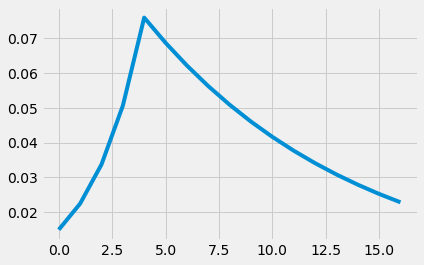

In [70]:
plt.plot(history.history['lr'])

## Submission File

In [71]:
distance_tst = calc_haversine(df_tst.LatitudeDegrees, df_tst.LongitudeDegrees, P_tst[:, 0] + df_tst.LatitudeDegrees, P_tst[:, 1] + df_tst.LongitudeDegrees)
print(f'CV All: {np.percentile(distance_tst, [50, 95])}')

CV All: [ 6.40205845 19.13388068]


In [72]:
df_tst.sort_values(['phone', 'UnixTimeMillis'], inplace=True)
df_tst_smoothed = df_tst.copy()
df_tst_smoothed['LatitudeDegrees'] = df_tst_smoothed['LatitudeDegrees'] + P_tst[:, 0]
df_tst_smoothed['LongitudeDegrees'] = df_tst_smoothed['LongitudeDegrees'] + P_tst[:, 1]
df_tst_smoothed = apply_kf_smoothing(df_tst_smoothed)
distance_tst = calc_haversine(df_tst.LatitudeDegrees, df_tst.LongitudeDegrees, df_tst_smoothed.LatitudeDegrees, df_tst_smoothed.LongitudeDegrees)
print(f'CV All (smoothed): {np.percentile(distance_tst, [50, 95])}')

CV All (smoothed): [ 6.59802349 19.00086101]


In [73]:
df_tst_smoothed = df_tst_smoothed.reindex(columns=['tripId', 'UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees']).sort_values(["tripId", "UnixTimeMillis"]).reset_index(drop=True)

In [74]:
df_tst_smoothed

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395733,-122.102850
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395771,-122.102942
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395799,-122.103002
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395818,-122.103034
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395830,-122.103046
...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656931,-121.899060
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.656941,-121.899050
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656940,-121.899006
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656930,-121.898931


In [75]:
# df_tst_smoothed.to_csv(submission_file, index=False)

In [76]:
sample_sub

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395801,-122.102883
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395828,-122.102943
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395845,-122.102977
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395860,-122.102991
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395874,-122.102999
...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656986,-121.899026
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.657002,-121.899043
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656991,-121.898983
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656984,-121.898891


In [77]:
df_tst_smoothed = df_tst_smoothed.merge(sample_sub, how='left', on=['tripId','UnixTimeMillis'])

In [78]:
df_tst_smoothed

,tripId,UnixTimeMillis,LatitudeDegrees_x,LongitudeDegrees_x,LatitudeDegrees_y,LongitudeDegrees_y
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395733,-122.102850,37.395801,-122.102883
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395771,-122.102942,37.395828,-122.102943
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395799,-122.103002,37.395845,-122.102977
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395818,-122.103034,37.395860,-122.102991
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395830,-122.103046,37.395874,-122.102999
...,...,...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656931,-121.899060,37.656986,-121.899026
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.656941,-121.899050,37.657002,-121.899043
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656940,-121.899006,37.656991,-121.898983
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656930,-121.898931,37.656984,-121.898891


In [79]:
df_tst_smoothed['LatitudeDegrees'] = (df_tst_smoothed['LatitudeDegrees_x'] + df_tst_smoothed['LatitudeDegrees_y'])/2
df_tst_smoothed['LongitudeDegrees'] = (df_tst_smoothed['LongitudeDegrees_x'] + df_tst_smoothed['LongitudeDegrees_y'])/2

In [80]:
df_tst_smoothed.drop(['LatitudeDegrees_y','LongitudeDegrees_y','LatitudeDegrees_x','LongitudeDegrees_x'], axis=1, inplace=True)

In [81]:
df_tst_smoothed

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650832999,37.395767,-122.102867
1,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650833999,37.395800,-122.102943
2,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650834999,37.395822,-122.102990
3,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650835999,37.395839,-122.103012
4,2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra,1619650836999,37.395852,-122.103023
...,...,...,...,...
66092,2022-04-25-US-OAK-2/GooglePixel4,1650927742650,37.656959,-121.899043
66093,2022-04-25-US-OAK-2/GooglePixel4,1650927743642,37.656971,-121.899047
66094,2022-04-25-US-OAK-2/GooglePixel4,1650927744651,37.656966,-121.898995
66095,2022-04-25-US-OAK-2/GooglePixel4,1650927745640,37.656957,-121.898911


In [82]:
df_tst_smoothed.to_csv('submission.csv', index=False)